# Wasserstein GAN (WGAN)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
import gzip
# torch.cuda.set_device(3)

## Download Dataset

Download the LSUN scene classification dataset bedroom category, unzip it, and convert it to jpg files (the scripts folder is here in the `dl2` folder):

```
curl 'http://lsun.cs.princeton.edu/htbin/download.cgi?tag=latest&category=bedroom&set=train' -o bedroom.zip
unzip bedroom.zip
pip install lmdb
python lsun-data.py {PATH}/bedroom_train_lmdb --out_dir {PATH}/bedroom
```

This isn't tested on Windows - if it doesn't work, you could use a Linux box to convert the files, then copy them over. Alternatively, you can download [this 20% sample](https://www.kaggle.com/jhoward/lsun_bedroom) from Kaggle datasets.

In [8]:
%mkdir data/lsun

In [9]:
%cd data/lsun

/home/ubuntu/data/lsun


In [ ]:
!aria2c --file-allocation=none -c -x 5 -s 5 'http://lsun.cs.princeton.edu/htbin/download.cgi?tag=latest&category=bedroom&set=train'

 *** Download Progress Summary as of Mon Jul  9 10:03:44 2018 ***              
[#98af93 2.1GiB/42GiB(4%) CN:5 DL:40MiB ETA:16m55s]
FILE: /home/ubuntu/data/lsun/bedroom_train_lmdb.zip
-------------------------------------------------------------------------------

 *** Download Progress Summary as of Mon Jul  9 10:04:45 2018 ***              
[#98af93 4.5GiB/42GiB(10%) CN:5 DL:40MiB ETA:15m57s]
FILE: /home/ubuntu/data/lsun/bedroom_train_lmdb.zip
-------------------------------------------------------------------------------

 *** Download Progress Summary as of Mon Jul  9 10:05:45 2018 ***              
[#98af93 6.9GiB/42GiB(16%) CN:5 DL:40MiB ETA:14m59s]
FILE: /home/ubuntu/data/lsun/bedroom_train_lmdb.zip
-------------------------------------------------------------------------------

 *** Download Progress Summary as of Mon Jul  9 10:06:46 2018 ***              
[#98af93 9.3GiB/42GiB(21%) CN:5 DL:40MiB ETA:14m8s]
FILE: /home/ubuntu/data/lsun/bedroom_train_lmdb.zip
-------------------

In [18]:
!unzip bedroom_train_lmdb.zip

Archive:  bedroom_train_lmdb.zip
   creating: bedroom_train_lmdb/
  inflating: bedroom_train_lmdb/lock.mdb  
  inflating: bedroom_train_lmdb/data.mdb  


In [23]:
%cd ~/fastai/courses/dl2/

/home/ubuntu/fastai/courses/dl2


In [19]:
!pip install lmdb

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [25]:
!python lsun_scripts/lsun-data.py data/lsun/bedroom_train_lmdb --out_dir data/lsun/bedroom

Exporting data/lsun/bedroom_train_lmdb to data/lsun/bedroom
3033042it [16:11, 3123.24it/s]


Define directory and file paths.

In [3]:
PATH = Path('data/lsun')
IMG_PATH = PATH / 'bedroom'
CSV_PATH = PATH / 'files.csv'
TMP_PATH = PATH / 'tmp'
TMP_PATH.mkdir(exist_ok=True)

## Handle our data

Generate a CSV with the list of files that we want. One CSV file contains everything in that bedroom dataset, and another one contains random 10%. It is nice to do that because then we can most of the time use the sample when we are experimenting because there is well over a million files even just reading in the list takes a while.

In [11]:
files = PATH.glob('bedroom/**/*.jpg')

with CSV_PATH.open('w') as fo:
    for f in files:
        fo.write(f'{f.relative_to(IMG_PATH)},0\n')

In [12]:
# Optional - sampling a subset of files

# Use the sample when we are experimenting because there is well over a million files
# even just reading in the list takes a while.
CSV_PATH = PATH / 'files_sample.csv'

In [13]:
files = PATH.glob('bedroom/**/*.jpg')

with CSV_PATH.open('w') as fo:
    for f in files:
        if random.random() < 0.1:
            fo.write(f'{f.relative_to(IMG_PATH)},0\n')

## Build a discriminator

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None:
            pad = ks // 2 // stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [6]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize, cndf = isize / 2, ndf
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1)
                                    for t in range(n_extra_layers)])

        pyr_layers = [] # pyramid layers
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf * 2, 4, 2))
            cndf *= 2
            csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)

## Generator

In [7]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [8]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf // 2, 4
        while tisize != isize:
            cngf *= 2
            tisize *= 2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]

        csize, cndf = 4, cngf
        while csize < isize // 2:
            layers.append(DeconvBlock(cngf, cngf // 2, 4, 2, 1))
            cngf //= 2
            csize *= 2

        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)

    def forward(self, input):
        return F.tanh(self.features(input))

## Create ModelData object

In [9]:
bs, sz, nz = 64, 64, 100

In [12]:
tfms = tfms_from_stats(inception_stats, sz)
md = ImageClassifierData.from_csv(PATH, 'bedroom', CSV_PATH, tfms=tfms, bs=128,
                                  skip_header=False, continuous=True)

In [13]:
md = md.resize(128)

In [14]:
x, _ = next(iter(md.val_dl))

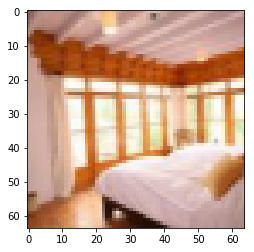

In [33]:
plt.imshow(md.trn_ds.denorm(x)[12])

## Putting them all together

In [34]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

In [35]:
def create_noise(b):
    return V(torch.zeros(b, nz, 1, 1).normal_(0, 1))

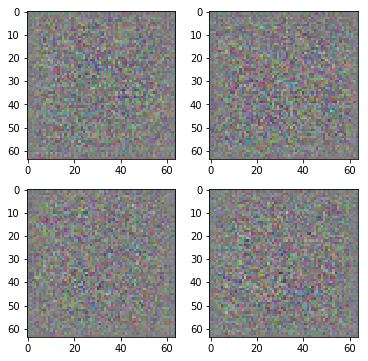

In [36]:
preds = netG(create_noise(4))
pred_ims = md.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(pred_ims[i])

In [37]:
def gallery(x, nc=3):
    n, h, w, c = x.shape
    nr = n // nc
    assert n == nr * nc
    return (x.reshape(nr, nc, h, w, c)
               .swapaxes(1, 2)
               .reshape(h * nr, w * nc, c))

Optimizer to update our gradients

In [38]:
optimizerD = optim.RMSprop(netD.parameters(), lr=1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr=1e-4)

Training loop

In [39]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train()
        netG.train()
        data_iter = iter(md.trn_dl)
        i, n = 0,len(md.trn_dl)
        with tqdm(total=n) as pbar:
            while i < n:
                set_trainable(netD, True)
                set_trainable(netG, False)
                d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5
                j = 0
                while (j < d_iters) and (i < n):
                    j += 1
                    i += 1
                    for p in netD.parameters():
                        p.data.clamp_(-0.01, 0.01)
                    real = V(next(data_iter)[0])
                    real_loss = netD(real)
                    fake = netG(create_noise(real.size(0)))
                    fake_loss = netD(V(fake.data))
                    netD.zero_grad()
                    lossD = real_loss - fake_loss
                    lossD.backward()
                    optimizerD.step()
                    pbar.update()

                set_trainable(netD, False)
                set_trainable(netG, True)
                netG.zero_grad()
                lossG = netD(netG(create_noise(bs))).mean(0).view(1)
                lossG.backward()
                optimizerG.step()
                gen_iterations += 1
            
        print(f'Loss_D {to_np(lossD)}; Loss_G {to_np(lossG)}; '
              f'D_real {to_np(real_loss)}; Loss_D_fake {to_np(fake_loss)}')

## Train

In [40]:
torch.backends.cudnn.benchmark = True

In [ ]:
train(1, False)

 46%|████▌     | 8690/18957 [38:32<43:51,  3.90it/s]  

In [ ]:
fixed_noise = create_noise(bs)

In [ ]:
set_trainable(netD, True)
set_trainable(netG, True)
optimizerD = optim.RMSprop(netD.parameters(), lr=1e-5)
optimizerG = optim.RMSprop(netG.parameters(), lr=1e-5)

In [ ]:
%time train(1, False)

Turn it back into something we can see, and then plot it.

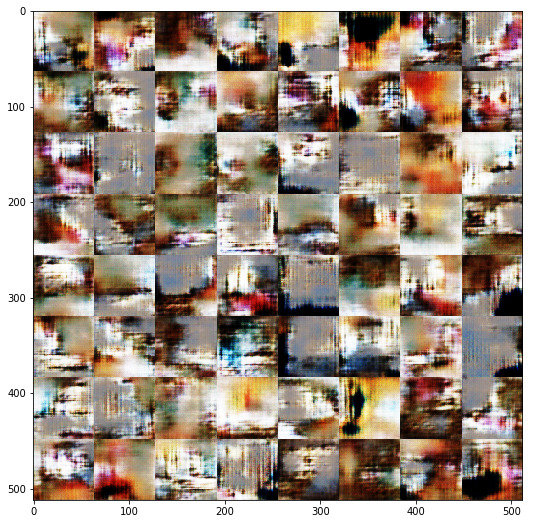

In [38]:
# Using sample data (10% random images)
netD.eval()
netG.eval()
fake = netG(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake), 0, 1)

plt.figure(figsize=(9, 9))
plt.imshow(gallery(faked, 8))

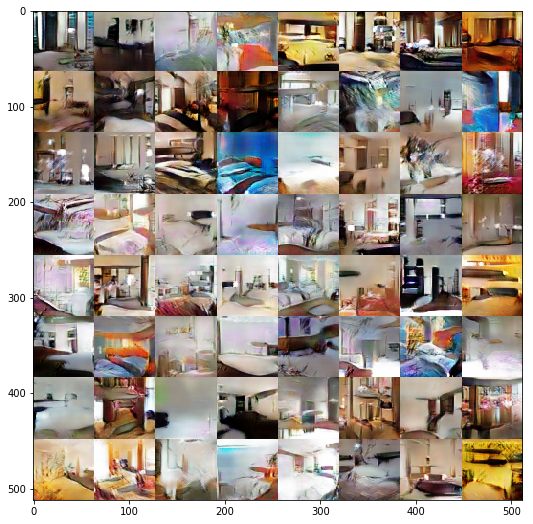

In [45]:
# Using the whole dataset
netD.eval()
netG.eval()
fake = netG(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake), 0, 1)

plt.figure(figsize=(9, 9))
plt.imshow(gallery(faked, 8))

Save work.

In [46]:
def save_state(net, fn):
    torch.save(net.state_dict(), TMP_PATH / fn)

In [47]:
save_state(netG, 'netG_full_data.h5')
save_state(netD, 'netD_full_data.h5')